# CS470 Introduction to Artificial Intelligent
## Deep Learning Practice 
#### TA. Jinsu Lim
#### School of Computing, KAIST

---

## 3. Convolutional Neural Network
### 3-6. Feature extraction using pre-trained models

The pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classificaton task. For the pre-trained model, we can either **use the pre-trained model as it is**, or **use transfer learning to customize this model** to a given task. 

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

In this notebook, we will try two ways to customize a pre-trained model:
1. **Feature Extraction**: To extract meaningful features from new samples. We will simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously on the large dataset. Please note that we will train the final parts of model, classification part of the pre-trained model, thus, we do not have to (re)train the entire model.
1. **Fine-tuning**: We will jointly train both the newly-added classifier layers and the last layers of the pre-trained model. This allows us to "fine tune" the higher-order feature representations in the pre-trained model in order to make them more relevant for the specific task.

In [6]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

#### Load the dataset

We will first download and load the cats and dogs dataset from the [`Tensorflow Datasets`](https://www.tensorflow.org/datasets). This [`tfds`](https://www.tensorflow.org/datasets/api_docs/python/tfds) package is the easiest way to load pre-defined data.

In [9]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method downloads and caches the data, and returns a [`tf.data.Dataset`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) objects. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Let's load `cats_vs_dogs` dataset and use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, and 10% of the data respectively.

In [10]:
# TODO: Load cats vs dogs image dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

2022-05-04 11:08:37.324219: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dataset cats_vs_dogs downloaded and prepared to /home/j1n2u/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


2022-05-04 11:10:18.081274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-04 11:10:18.098766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-04 11:10:18.098787: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-04 11:10:18.099146: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

The resulting [`tf.data.Dataset`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) objects contain **(image, label) pairs**. Where the images have variable shape and 3 channels, and the label is a scalar.

In [11]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Let's display the first two images and labels from the training set:

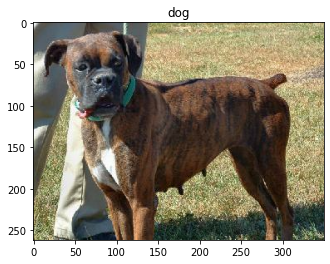

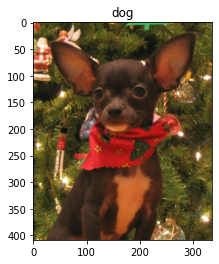

In [12]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

#### Preprocess the dataset
Let's preprocess the images for the task:
- Rescale the input channels to a range of [-1, 1]
- Resize the images to a fixes input size

First, we will define the `preprocess_example()` function.

In [17]:
IMG_SIZE = 160 # All images will be resized to 160x160

def preprocess_example(image, label):
    # TODO: Cast the image vector as tf.float32
    image = tf.cast(image, tf.float32)
    # TODO: Rescale the input channels to a range of [-1, 1]
    image = (image/127.5) - 1 
    # TODO: Resize the images to a fixes input size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

Then, we can apply the defined function to the dataset using [`tf.data.Dataset.map()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#map).

In [18]:
# TODO: Apply process_example() to dataset
train = raw_train.map(preprocess_example)
validation = raw_validation.map(preprocess_example)
test = raw_test.map(preprocess_example)

After that, we are going to randomly shuffle the dataset using [`tf.data.Dataset.shuffle()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#shuffle) and combine consecutive items of the dataset into batches using [`tf.data.Dataset.batch()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#batch).

In [19]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

# TODO: Shuffle the dataset and combine them into batches
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Let's inspect a batch of data:

In [20]:
image_batch, label_batch = next(iter(train_batches.take(1)))
print(image_batch.shape)
print(label_batch.shape)

(64, 160, 160, 3)
(64,)


#### Build the model from the pre-trained convolutional neural network
![Convolutional neural network](images/cnn-architectures.png?raw=true)

We are going to build the model from the MobileNet V2. First, we need to choose which layer of the model we will use for the feature extraction. Obviously, the very last classification layer is not very useful. Thus, we will use all the layers before the flatten operation. The last layer before the flatten operation is called the "*bottleneck layer*" and bottleneck features retain much generality as compared to the final classification layer.

To do this, let's instantiate the MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we can load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# TODO: Load MobileNetV2 without the final classification layer
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


This feature extractor converts each 160x160x3 image to a 5x5x1280 block of features. Let' see what it does to the example batch of images:

In [22]:
feature_batch = base_model(image_batch)
print(image_batch.shape,  '->', feature_batch.shape)

(64, 160, 160, 3) -> (64, 5, 5, 1280)


#### Freeze the convolutional blocks for feature extraction

We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

It's important to freeze the convolutional based before we compile and train the model. By freezing (or **setting layer.trainable = False**), we prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [23]:
# TODO: Freeze the base model
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

#### Add the classification layer

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

To generate predictions from the block of features, let's add the following layers:
- `tf.keras.layers.GlobalAveragePooling2D`:  Layer to convert the features to a single 1280-element vector per image
    - This layer converts (32, 5, 5, 1280) tensor into (32, 1280) by averaging 5x5 feature maps
- `tf.keras.layers.Dense`:  Layer to classify the input vector as cat or dog

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [28]:
# TODO: Add the classification layer
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compile the model
You must compile the model before training it. Since there are two classes, let's use a binary cross-entropy loss.

In [31]:
learning_rate = 0.0001

# TODO: Compile the model with the following paramters:
# - optimizer: RMSprop
# - loss: binary crossentropy
# - metrics: accuracy
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/home/j1n2u/.local/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.3M parameters in MobileNet are frozen, but there are 1.3K trainable parameters in the Dense layer.

#### Train the model

In [33]:
loss0, accuracy0 = model.evaluate(validation_batches, steps=10)

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 5/10 [==============>...............] - ETA: 1s - loss: 3.9244 - accuracy: 0.5719

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


10/10 [==============================] - 3s 282ms/step - loss: 4.5076 - accuracy: 0.5188


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.51
initial accuracy: 0.52


The accuracy is same to randomly select the answer. So, we will check an accuracy after training the model.

In [35]:
initial_epochs = 10

# Train the model
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches,
)

Epoch 1/10
 82/291 [=======>......................] - ETA: 56s - loss: 2.9143 - accuracy: 0.6471

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 98/291 [=========>....................] - ETA: 52s - loss: 2.7922 - accuracy: 0.6615

103/291 [=========>....................] - ETA: 50s - loss: 2.7591 - accuracy: 0.6650

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


139/291 [=============>................] - ETA: 41s - loss: 2.5698 - accuracy: 0.6872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


243/291 [========================>.....] - ETA: 13s - loss: 2.0574 - accuracy: 0.7443

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


249/291 [========================>.....] - ETA: 11s - loss: 2.0385 - accuracy: 0.7470

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


255/291 [=========================>....] - ETA: 9s - loss: 2.0146 - accuracy: 0.7501 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


268/291 [==========================>...] - ETA: 6s - loss: 1.9769 - accuracy: 0.7551

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


271/291 [==========================>...] - ETA: 5s - loss: 1.9654 - accuracy: 0.7564

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 1.8969 - accuracy: 0.7642

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


291/291 [==============================] - 89s 302ms/step - loss: 1.8969 - accuracy: 0.7642 - val_loss: 0.9197 - val_accuracy: 0.8818
Epoch 2/10
 13/291 [>.............................] - ETA: 1:16 - loss: 0.8271 - accuracy: 0.8930

KeyboardInterrupt: 

![Feature Extraction Epochs](images/feature-extraction-epochs.PNG?raw=true)

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

![Feature Extraction Graph](images/feature-extraction-graph.PNG?raw=true)

### 3-6. Fine tuning the model

In the previous feature extraction part, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


#### Unfreeze the top layers of the model
All we need to do is unfreeze the `base_model` and set the bottom layers be untrainable. (i.e., we will fine-tune a small number of top layers of base mode). Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [38]:
# TODO: Unfreeze the base model
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# TODO: Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


#### Compile the model
Let's compile the model using a much lower training rate.

In [40]:
# TODO: Compile the model with the following paramters:
# - optimizer: RMSprop
# - loss: binary crossentropy
# - metrics: accuracy

model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


#### Train the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_tuned = model.fit(
    train_batches,
     epochs=total_epochs,
     initial_epoch=initial_epochs,
     validation_data=validation_batches)

![Fine Tuning Epochs](images/fine-tuning-epochs.PNG?raw=true)

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

In [ ]:
acc += history_fine_tuned.history['accuracy']
val_acc += history_fine_tuned.history['val_accuracy']

loss += history_fine_tuned.history['loss']
val_loss += history_fine_tuned.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

![Fine Tuning Graph](images/fine-tuning-graph.PNG?raw=true)